# Pytorch classifier notebook

V1 : only 1 split. First implementation  
V2 : with all folds

In [305]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

DATASET_INPUT_FILE = 'train.csv'

FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)]

# For custom non-overlaped folds generation
TRAIN_PERCENT = 0.70  
TEST_PERCENT = 0.30

#pd.set_option('display.max_rows', 500)

In [306]:
# Deterministic Behavior
seed = 42
#os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
#random.seed(seed)
# CuDA Determinism
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [307]:
#BATCH_SIZE = 50000
#BATCH_SIZE = 4096 # Gave once better results than 50000
#BATCH_SIZE = 2048

#BATCH_SIZE = 300000

#BATCH_SIZE = 4096
BATCH_SIZE = 8192

NUM_EPOCHS = 100
MODEL_COMMENT = "All folds, 3 layers 130, 2000 and 1000, good model reloaded, batch size 8192, lr=1e-4, patience 5, standard scale, 0.7 dropout"

In [308]:
def pyStandardScale(tensor, mean, std):
    return((tensor - mean) / std)

In [309]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

from matplotlib.colors import ListedColormap
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv_indices_custom(cv_custom, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_custom):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [310]:
# This function accounts for variable instance counts in each split by dividing utility_pi by number of instances (but this has been removed)
# It also does some copy of dataframe to prevent memory overwrite
def utility_function(df_test, df_test_predictions):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy.loc[:, 'utility_pj'] = df_test_copy['weight'] * df_test_copy['resp'] * df_test_predictions
    #df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum() / df_test_copy.groupby('date')['utility_pj'].count()
    df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum()

    nb_unique_dates = df_test_utility_pi.shape[0]
    t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))
    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    del df_test_copy
    
    return(u)

In [311]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

In [312]:
#fig, ax = plt.subplots(1, 1)
#
#plot_cv_indices(cv, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20);

In [313]:
torch.device

torch.device

In [314]:
torch.cuda.is_available()

True

In [315]:
torch.cuda.current_device()

0

In [316]:
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

# Load data

In [317]:
# Load data
    
df = pd.read_csv(DATASET_INPUT_FILE)
df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict

print('Data loaded')


Data loaded


# Non overlap fold generation

In [318]:
date_indexes_list = df.groupby('date')['ts_id'].first().to_list()

In [319]:
base_train_split_size = int((df.shape[0] // 5) * TRAIN_PERCENT)

In [320]:
base_test_split_size = int((df.shape[0] // 5) * TEST_PERCENT)

In [321]:
train_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [322]:
test_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [323]:
train_split_start_indexes

[0, 477711, 958233, 1435933, 1913985]

In [324]:
df.shape[0] - 1

2390490

In [325]:
NB_FOLDS = 5
last_index = df.shape[0] - 1

cv_table = []

for fold_indice in range(NB_FOLDS):
    fold_train_start_index = train_split_start_indexes[fold_indice]
    
    if (fold_indice == NB_FOLDS - 1):    
        nextfold_train_start_index = last_index
        
    else:
        nextfold_train_start_index = train_split_start_indexes[fold_indice + 1]
    
    fold_test_start_index = take_closest(date_indexes_list, int(TRAIN_PERCENT * (nextfold_train_start_index - fold_train_start_index) + fold_train_start_index  ))
    
    cv_table.append(fold_train_start_index)
    cv_table.append(fold_test_start_index)

In [326]:
cv_table.append(last_index)

In [327]:
cv_tuples = []

for i in range(0, NB_FOLDS*2, 2):
    cv_tuples.append([df.loc[cv_table[i]:cv_table[i+1]-1, :].index.to_list(), df.loc[cv_table[i+1]:cv_table[i+2]-1, :].index.to_list()])

In [328]:
cv_tuples_generator = iter(cv_tuples)

In [329]:
#fig, ax = plt.subplots(1, 1)

#plot_cv_indices_custom(cv_tuples_generator, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20); 

#cv_tuples_generator = iter(cv_tuples)

In [330]:
# Size of training set :
#train_sets_table =  [cv_tuples[i][0] for i in range(5)]
#sum([len(train_set_table) for train_set_table in train_sets_table])

In [331]:
# Our old time series split (with overlap : required 1 neural network trained per split)
# But in this script it's not needed because we're training 1 unique network, with a different fold strategy (non overlaped)
#cv = PurgedGroupTimeSeriesSplit(
#    n_splits=5,
#    max_train_group_size=180,
#    group_gap=20,
#    max_test_group_size=60
#)

In [332]:
#train_index, test_index = next(cv.split(df, (df['resp'] > 0)*1, df['date']))

In [333]:
#(df.loc[train_index, 'resp'] > 0).astype(np.byte)

In [334]:
f_mean = df.loc[:, FEATURES_LIST_TOTRAIN].mean(axis=0)

In [335]:
f_mean.shape

(130,)

In [336]:
df.fillna(f_mean, inplace=True)

In [337]:
#print('Sum of model parameters:')
#[print(p.sum()) for p in model.parameters()]

In [338]:
#writer = SummaryWriter()

#writer.add_text('test', 'test:'  + str(model).replace('\n', '<BR>'))

#writer.flush()
#writer.close()

In [339]:
#str([p.numel() for p in model.parameters()])

In [340]:
folds_list = []

for fold, (train_index, test_index) in enumerate(cv_tuples_generator):
    folds_list.append((train_index, test_index))

In [341]:
folds_list_train = [folds_list[i][0] for i in range(5)]
folds_list_train_flat = [folds_list_train_item for sublist in folds_list_train for folds_list_train_item in sublist]
folds_list_train_unique = list(set(folds_list_train_flat))

In [342]:
len(folds_list_train_unique)

1677155

In [343]:
np.sum([len(folds_list_train_item) for folds_list_train_item in folds_list_train])

1677155

In [344]:
len(folds_list_train_flat)

1677155

In [345]:
folds_list_test = [folds_list[i][1] for i in range(5)]
folds_list_test_flat = [folds_list_test_item for sublist in folds_list_test for folds_list_test_item in sublist]
folds_list_test_unique = set(folds_list_test_flat)

In [346]:
np.sum([len(folds_list_test_item) for folds_list_test_item in folds_list_test])

713335

In [347]:
len(folds_list_test_flat)

713335

In [348]:
len(folds_list_train_flat) + len(folds_list_test_flat)

2390490

In [349]:
df.loc[folds_list_test[4], FEATURES_LIST_TOTRAIN].to_numpy().shape

(141980, 130)

In [350]:
patience=5

utility_scores = [None] * 5
accuracy_scores = [None] * 5

writer = SummaryWriter()

ts_train = torch.tensor(df.loc[folds_list_train_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

# Normalize data
ts_train_mean = torch.mean(ts_train, axis=0)
ts_train_std = torch.std(ts_train, axis=0)
ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # pin_memory : VOIR RESULTAT

ts_test = [None] * 5
ts_test_y = [None] * 5    
test_dataset = [None] * 5
test_loader = [None] * 5

for fold_indice in range(5):
    ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize
    ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)
    
    test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice])
    test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE)

torch.manual_seed(seed)

model = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 2000),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),

        nn.Linear(2000, 1000),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),
    
        nn.Linear(1000, 1),
        nn.Sigmoid(),
    ).double().to('cuda')

print('Number of model parameters :')
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

loss_fn = nn.BCELoss().to('cuda')
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

model.eval()
#start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
#start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
#print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
#print('Start Validation Utility: {:.4f}'.format(start_utility_score))

Val_Loss = 0
N_Samples = 0

the_last_loss = 100
the_last_utility_score = 0
the_last_accuracy = 0
trigger_times=0
early_stopping_met = False

for epoch in range(NUM_EPOCHS): 
    running_loss = 0.0        
    model.train()

    for batch in train_loader:
        #inputs, labels = batch[0], batch[1]
        inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(-1).double())
            loss.backward()
            optimizer.step()

    # update local train loss
        running_loss += loss.item() * inputs.size(0)

    # update global train loss
    epoch_loss = running_loss / len(train_loader.dataset)
    print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

    writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

    # Validation 
    model.eval()

    vrunning_loss = [None] * 5
    num_samples = [None] * 5
    vepoch_loss_folds = [None] * 5
    vepoch_accuracy_folds = [None] * 5
    vepoch_utility_score_folds = [None] * 5
    
    for fold_indice in range(5):    
        vrunning_loss[fold_indice] = 0.0
        num_samples[fold_indice] = 0

        for batch in test_loader[fold_indice]:
            inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

            optimizer.zero_grad()
            with torch.no_grad():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels.unsqueeze(-1).double())

            vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
            num_samples[fold_indice] += labels.size(0)
            
            vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

        print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))

        model.eval()
        with torch.no_grad():
            vepoch_accuracy_folds[fold_indice] = accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
            vepoch_utility_score_folds[fold_indice] = utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
        print('Epoch({}) - Fold {} - Validation Accuracy : {:.4f}'.format(epoch, fold_indice, vepoch_accuracy_folds[fold_indice]))
        print('Epoch({}) - Fold {} - Validation Utility score : {:.4f}'.format(epoch, fold_indice, vepoch_utility_score_folds[fold_indice]))
        
            
    # update epoch loss
    vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
    vepoch_accuracy = sum(vepoch_accuracy_folds) / len(vepoch_accuracy_folds)
    vepoch_utility_score = sum(vepoch_utility_score_folds) #/ len(vepoch_utility_score_folds)
    print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))
    print('Epoch({}) - GLOBAL - Validation Accuracy: {:.4f}'.format(epoch, vepoch_accuracy))
    print('Epoch({}) - GLOBAL - Validation Utility score: {:.4f}'.format(epoch, vepoch_utility_score))

    #print(f'Sum of model parameters ({epoch}):')
    #[print(p.sum()) for p in model.parameters()]

    writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)
    writer.add_scalar("Global valid/Accuracy", vepoch_accuracy, epoch)
    writer.add_scalar("Global valid/Utility", vepoch_utility_score, epoch)

    for fold_indice in range(5):
        writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)
        writer.add_scalar("Fold valid Accuracy/Accuracy fold "+str(fold_indice), vepoch_accuracy_folds[fold_indice], epoch)
        writer.add_scalar("Fold valid Utility/Utility fold "+str(fold_indice), vepoch_utility_score_folds[fold_indice], epoch)
        
    
    writer.flush()

    # Check if Early Stopping
    #if vepoch_loss > the_last_loss:
    #if (vepoch_utility_score < the_last_utility_score) and (vepoch_loss > the_last_loss) and (vepoch_accuracy < the_last_accuracy):
    if (vepoch_loss > the_last_loss):
        trigger_times += 1

        print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')
        #print(f'Intermediate early stopping : vepoch_accuracy = {vepoch_accuracy:.4f}, the_last_utility_score={the_last_accuracy:.4f}')
        #print(f'Intermediate early stopping : vepoch_utility_score = {vepoch_utility_score:.4f}, the_last_utility_score={the_last_utility_score:.4f}')

        if trigger_times >= patience:
            print('Meet Early stopping!')
            early_stopping_met = True
            ##torch.save(model.state_dict(), f'model_{fold}.pt')
            break
    else:
        trigger_times = 0
        the_last_loss = vepoch_loss
        the_last_utility_score = vepoch_utility_score
        the_last_accuracy = vepoch_accuracy
        
        the_last_utility_score_folds = vepoch_utility_score_folds
        the_last_accuracy_folds = vepoch_accuracy_folds
        
        the_best_epoch = epoch

        # Save model for the best version so far
        print(f'Saving model corresponding to last_utility_score == {the_last_utility_score}')
        torch.save(model.state_dict(), f'model_NN_allfolds_V1.pt')

    print('\n')

if (early_stopping_met == False):
    print("Didn't meet early stopping : saving final model")
    # Save model if don't meet early stopping
    torch.save(model.state_dict(), f'model_NN_allfolds_V1.pt')

#utility_scores.append(the_last_utility_score)
#accuracy_scores.append(the_last_accuracy)
writer.add_text(f"Global valid/Utility", f"Best utility: {the_last_utility_score}", the_best_epoch)
        
scores_results = {'utility_score': the_last_utility_score, 'utility_scores': the_last_utility_score_folds, 'utility_score_std': np.std(the_last_utility_score_folds), 'accuracy_scores': the_last_accuracy_folds}

writer.add_text('Final utility score', str(scores_results))
writer.add_text('Batch size', str(BATCH_SIZE))
writer.add_text('Patience', str(patience))
writer.add_text('Number of epochs', str(NUM_EPOCHS))
writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
writer.add_text('Comment', MODEL_COMMENT)

writer.close()

print('Training summary:')
print(scores_results)

Number of model parameters :
Epoch(0) - Training Loss: 0.6947
Epoch(0) - Fold 0 - Validation Loss : 0.6919
Epoch(0) - Fold 0 - Validation Accuracy : 0.5256
Epoch(0) - Fold 0 - Validation Utility score : 463.4892
Epoch(0) - Fold 1 - Validation Loss : 0.6920
Epoch(0) - Fold 1 - Validation Accuracy : 0.5222
Epoch(0) - Fold 1 - Validation Utility score : 816.2697
Epoch(0) - Fold 2 - Validation Loss : 0.6928
Epoch(0) - Fold 2 - Validation Accuracy : 0.5068
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6927
Epoch(0) - Fold 3 - Validation Accuracy : 0.5132
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6918
Epoch(0) - Fold 4 - Validation Accuracy : 0.5250
Epoch(0) - Fold 4 - Validation Utility score : 1359.9272
Epoch(0) - GLOBAL - Validation Loss: 0.6922
Epoch(0) - GLOBAL - Validation Accuracy: 0.5186
Epoch(0) - GLOBAL - Validation Utility score: 2639.6860
Saving model corresponding to last_utilit

In [351]:
model

Sequential(
  (0): Linear(in_features=130, out_features=2000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.7, inplace=False)
  (3): Linear(in_features=2000, out_features=1000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.7, inplace=False)
  (6): Linear(in_features=1000, out_features=1, bias=True)
  (7): Sigmoid()
)

In [352]:
model[0]

Linear(in_features=130, out_features=2000, bias=True)

In [353]:
model

Sequential(
  (0): Linear(in_features=130, out_features=2000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.7, inplace=False)
  (3): Linear(in_features=2000, out_features=1000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.7, inplace=False)
  (6): Linear(in_features=1000, out_features=1, bias=True)
  (7): Sigmoid()
)

In [354]:
model[3]

Linear(in_features=2000, out_features=1000, bias=True)

In [364]:
for i, param_object in enumerate(model[0].parameters()):
    print(f'Object {i}')
    print(param_object.shape)
    print(param_object)

Object 0
torch.Size([2000, 130])
Parameter containing:
tensor([[ 0.0650,  0.0685,  ...,  0.0744, -0.0119],
        [ 0.0825,  0.0308,  ...,  0.0429,  0.0432],
        ...,
        [ 0.0224,  0.0022,  ..., -0.0378, -0.0550],
        [-0.0605, -0.0572,  ...,  0.0104, -0.0042]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)
Object 1
torch.Size([2000])
Parameter containing:
tensor([ 0.0715, -0.0130,  ..., -0.0664, -0.0297], device='cuda:0',
       dtype=torch.float64, requires_grad=True)


In [356]:
help(model[4])

Help on ReLU in module torch.nn.modules.activation object:

class ReLU(torch.nn.modules.module.Module)
 |  ReLU(inplace: bool = False)
 |  
 |  Applies the rectified linear unit function element-wise:
 |  
 |  :math:`\text{ReLU}(x) = (x)^+ = \max(0, x)`
 |  
 |  Args:
 |      inplace: can optionally do the operation in-place. Default: ``False``
 |  
 |  Shape:
 |      - Input: :math:`(N, *)` where `*` means, any number of additional
 |        dimensions
 |      - Output: :math:`(N, *)`, same shape as the input
 |  
 |  .. image:: ../scripts/activation_images/ReLU.png
 |  
 |  Examples::
 |  
 |      >>> m = nn.ReLU()
 |      >>> input = torch.randn(2)
 |      >>> output = m(input)
 |  
 |  
 |    An implementation of CReLU - https://arxiv.org/abs/1603.05201
 |  
 |      >>> m = nn.ReLU()
 |      >>> input = torch.randn(2).unsqueeze(0)
 |      >>> output = torch.cat((m(input),m(-input)))
 |  
 |  Method resolution order:
 |      ReLU
 |      torch.nn.modules.module.Module
 |      builti

In [357]:
for i, param_object in enumerate(model[0].parameters()):
    print(f'Object {i}')
    print(param_object.shape)
    print(param_object)

Object 0
torch.Size([2000, 130])
Parameter containing:
tensor([[ 0.0650,  0.0685,  ...,  0.0744, -0.0119],
        [ 0.0825,  0.0308,  ...,  0.0429,  0.0432],
        ...,
        [ 0.0224,  0.0022,  ..., -0.0378, -0.0550],
        [-0.0605, -0.0572,  ...,  0.0104, -0.0042]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)
Object 1
torch.Size([2000])
Parameter containing:
tensor([ 0.0715, -0.0130,  ..., -0.0664, -0.0297], device='cuda:0',
       dtype=torch.float64, requires_grad=True)


In [358]:
#model.eval()
#accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())

In [359]:
#model.eval()
#utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())

In [360]:
'''
model_load = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 60),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(60, 30),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
       
        nn.Linear(30, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
    
model_load.load_state_dict(torch.load(f'model_NN_allfolds_V1.pt',map_location=torch.device('cuda')))
'''

#model_load.eval()
#print(accuracy_score(ts_test_y.cpu().numpy(), (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))
#
#model_load.eval()
#print(utility_function(df.loc[test_index], (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))


"\nmodel_load = nn.Sequential(\n        #nn.Dropout(0.2),\n        nn.Linear(len(FEATURES_LIST_TOTRAIN), 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),\n\n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n\n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n\n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n\n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n\n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n    \n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n    \n        nn.Linear(130, 130),\n        #nn.BatchNorm1d(130),\n        nn.ReLU(),\n        nn.Dropout(0.3),    \n\n        nn

# Data for model inference

## First, fill NA with :

In [361]:
f_mean

feature_0      0.009839
feature_1      0.385578
feature_2      0.357687
feature_3      0.008919
feature_4      0.004150
                 ...   
feature_125    0.244875
feature_126    0.339178
feature_127    0.232381
feature_128    0.342561
feature_129    0.245618
Length: 130, dtype: float64

## Then, normalize with :

In [362]:
ts_train_mean

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [363]:
ts_train_std

tensor([ 1.0000,  2.5724,  2.4543,  1.9501,  1.7327,  1.7503,  1.6707,  1.6297,
         1.8147,  2.4146,  1.7088,  1.6546,  2.3538,  2.2777,  2.0171,  1.8925,
         2.2236,  1.5821,  1.9931,  1.7196,  1.9315,  2.4339,  1.7864,  2.1404,
         2.6117,  2.0852,  2.2918,  1.4115,  1.8827,  1.7403,  2.0817,  1.6850,
         2.4817,  1.9481,  2.0704,  2.4316,  2.2853,  2.0566,  2.1225,  1.6162,
         2.3138,  1.9912,  2.4127,  2.3259,  2.7887,  1.9650,  2.8462,  2.2005,
         3.0387,  3.5713,  3.7193,  2.8348,  1.8877,  2.2007,  1.9352,  7.1295,
        11.0556,  7.5957,  8.1579,  9.9465,  2.2164,  1.9947,  2.1712,  2.2567,
         2.3735,  2.1915,  1.7553,  2.5883,  2.5263,  2.2991,  2.4406,  1.8076,
         1.8125,  2.1476,  1.7792,  1.9738,  2.2283,  2.6795,  2.1807,  1.7949,
         1.7688,  2.2805,  1.9767,  2.4821,  1.9748,  2.4948,  1.9679,  2.6387,
         2.5943,  2.6160,  2.0864,  2.6942,  2.0670,  2.2104,  2.1212,  2.5054,
         2.1243,  2.5619,  2.3017,  2.11

In [576]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        print(type(module_out))
        
    def clear(self):
        self.outputs = []

In [577]:
model2 =  nn.Sequential(
        nn.Linear(4, 2),
        nn.ReLU(),

        nn.Linear(2, 2),
        nn.ReLU(),


    
        nn.Linear(2, 1),
        nn.Sigmoid(),

)

model2.eval()

Sequential(
  (0): Linear(in_features=4, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=1, bias=True)
  (5): Sigmoid()
)

In [578]:
for i, param_object in enumerate(model2.parameters()):
    print(f'Object {i}')
    print(param_object.shape)
    print(param_object.data)

Object 0
torch.Size([2, 4])
tensor([[-0.2763,  0.3851, -0.2556, -0.4877],
        [ 0.0357, -0.1960,  0.0569,  0.4818]])
Object 1
torch.Size([2])
tensor([-0.4964,  0.2155])
Object 2
torch.Size([2, 2])
tensor([[-0.5303, -0.5134],
        [-0.3836,  0.2876]])
Object 3
torch.Size([2])
tensor([0.5339, 0.6289])
Object 4
torch.Size([1, 2])
tensor([[0.3987, 0.4664]])
Object 5
torch.Size([1])
tensor([-0.0542])


In [579]:
'activation' in str(type(model2[1]))

True

In [580]:
isinstance(model2[1], torch.nn.ReLU)

True

In [581]:
save_output = SaveOutput()

hook_handles = []

for layer in model2.modules():
    if ('activation' in str(type(layer))):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [582]:
hook_handles

In [602]:
#with torch.no_grad():
print(model2(torch.tensor([1, 1, 1, 2], dtype=torch.float)))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([0.5947], grad_fn=<SigmoidBackward>)


In [588]:
save_output.outputs

[tensor([0.0000, 1.0757]), tensor([0.0000, 0.9383]), tensor([0.5947])]

In [554]:
activation.append([0.11, 01.11])

In [600]:
# Pour récupérer les gradients : https://discuss.pytorch.org/t/how-to-print-the-computed-gradient-values-for-a-network/34179
print(model2[0].weight.grad)

None


In [606]:
model

Sequential(
  (0): Linear(in_features=130, out_features=2000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.7, inplace=False)
  (3): Linear(in_features=2000, out_features=1000, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.7, inplace=False)
  (6): Linear(in_features=1000, out_features=1, bias=True)
  (7): Sigmoid()
)

# Test

In [652]:
patience=5

utility_scores = [None] * 5
accuracy_scores = [None] * 5

ts_train = torch.tensor(df.loc[folds_list_train_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

# Normalize data
ts_train_mean = torch.mean(ts_train, axis=0)
ts_train_std = torch.std(ts_train, axis=0)
ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # pin_memory : VOIR RESULTAT

ts_test = [None] * 5
ts_test_y = [None] * 5    
test_dataset = [None] * 5
test_loader = [None] * 5

for fold_indice in range(5):
    ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize
    ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)
    
    test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice])
    test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE)

torch.manual_seed(seed)

model = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 50),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(50, 20),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),
    
        nn.Linear(20, 1),
        nn.Sigmoid(),
    ).double().to('cuda')

loss_fn = nn.BCELoss().to('cuda')
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

model.eval()
#start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
#start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
#print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
#print('Start Validation Utility: {:.4f}'.format(start_utility_score))

class SaveOutputActivationStats:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        #self.outputs.append(module_out)
        self.outputs.append({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        
    def clear(self):
        self.outputs = []

hook_handles = []
save_output_activation_stats = []

for layer in model.modules():
    if ('activation' in str(type(layer))):
        save_output_activation_stats_1layer = SaveOutputActivationStats()
        handle = layer.register_forward_hook(save_output_activation_stats_1layer)
        save_output_activation_stats.append(save_output_activation_stats_1layer)
        hook_handles.append(handle)

Val_Loss = 0
N_Samples = 0

the_last_loss = 100
the_last_utility_score = 0
the_last_accuracy = 0
trigger_times=0
early_stopping_met = False




epoch = 0

running_loss = 0.0        
model.train()

for batch in train_loader:
    #inputs, labels = batch[0], batch[1]
    inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(-1).double())
        loss.backward()
        optimizer.step()

# update local train loss
    running_loss += loss.item() * inputs.size(0)

# update global train loss
epoch_loss = running_loss / len(train_loader.dataset)
print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))


Epoch(0) - Training Loss: 0.6934


In [641]:
len(save_output_activation_stats.outputs)

615

In [653]:
save_output_activation_stats

In [660]:
pd.DataFrame(save_output_activation_stats[0].outputs)

,mean,std,near_zero
0,0.202752,0.336518,0.535918
1,0.203848,0.345865,0.536560
2,0.203794,0.348174,0.536831
3,0.203259,0.343263,0.534746
4,0.204196,0.342250,0.536084
...,...,...,...
200,0.195202,0.340713,0.537939
201,0.192681,0.314948,0.536843
202,0.193379,0.321594,0.537312
203,0.192954,0.329852,0.537407


In [674]:
df_stats_layer0

,mean,std,near_zero
0,0.202752,0.336518,0.535918
1,0.203848,0.345865,0.536560
2,0.203794,0.348174,0.536831
3,0.203259,0.343263,0.534746
4,0.204196,0.342250,0.536084
...,...,...,...
200,0.195202,0.340713,0.537939
201,0.192681,0.314948,0.536843
202,0.193379,0.321594,0.537312
203,0.192954,0.329852,0.537407


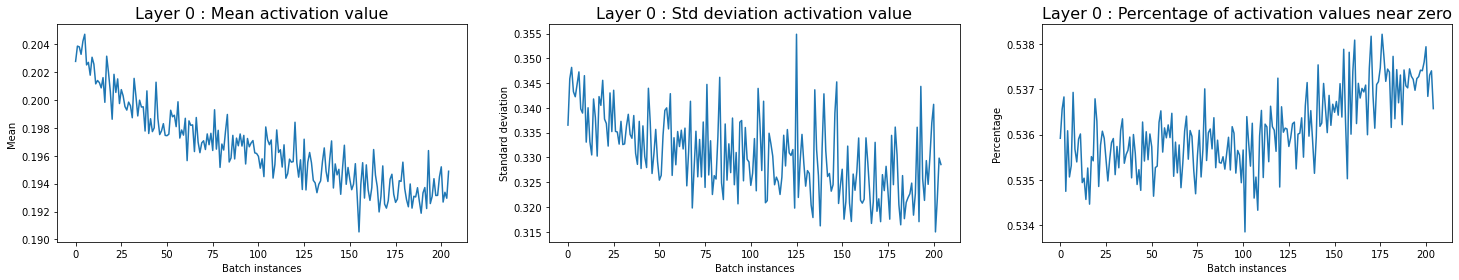

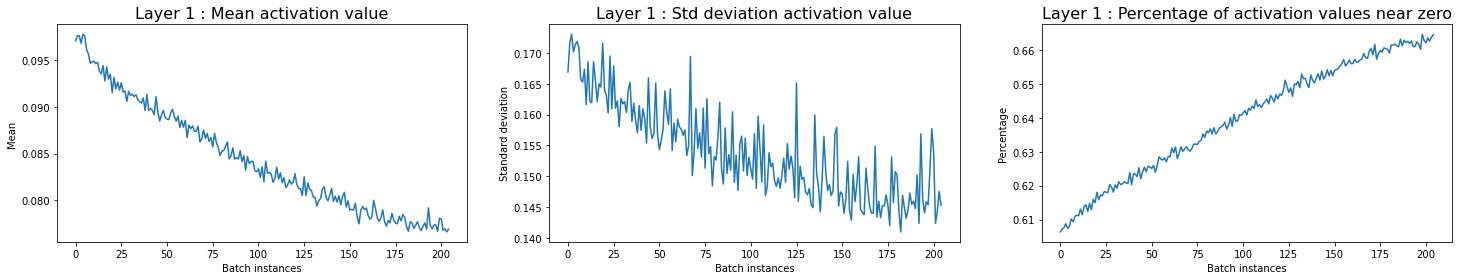

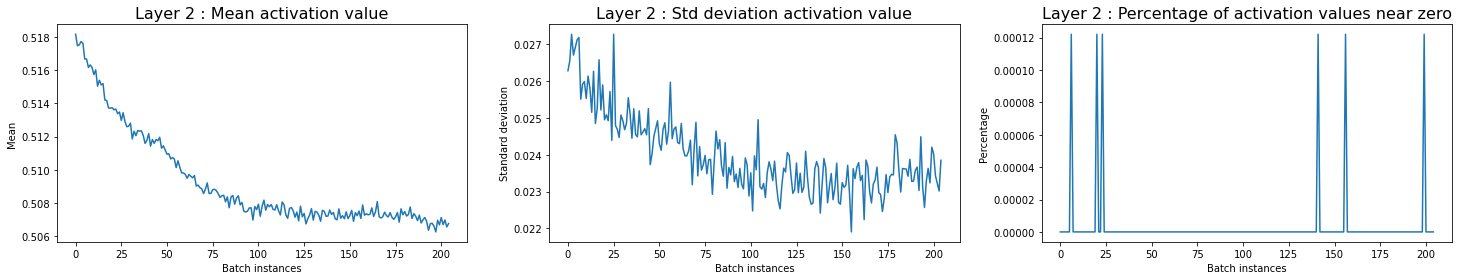

In [699]:
for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
    df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

    fig, ax = plt.subplots(1, 3, figsize=(25, 4))

    ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
    ax[0].set_xlabel('Batch instances')
    ax[0].set_ylabel('Mean')
    ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

    ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
    ax[1].set_xlabel('Batch instances')
    ax[1].set_ylabel('Standard deviation')
    ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

    ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
    ax[2].set_xlabel('Batch instances')
    ax[2].set_ylabel('Percentage')
    ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

In [648]:
len(save_output_activation_stats.outputs)

615

In [642]:
save_output_activation_stats.outputs

[{'mean': 0.20275246617262663,
  'std': 0.3365176322706607,
  'near_zero': 0.53591796875},
 {'mean': 0.09707760223429683,
  'std': 0.16690713159002724,
  'near_zero': 0.60635986328125},
 {'mean': 0.5181751273315416, 'std': 0.026281630987422214, 'near_zero': 0.0},
 {'mean': 0.20384796985610495,
  'std': 0.3458648143456899,
  'near_zero': 0.53656005859375},
 {'mean': 0.09763435613863332,
  'std': 0.17160990957845287,
  'near_zero': 0.607196044921875},
 {'mean': 0.5174823819125334, 'std': 0.02655162073734112, 'near_zero': 0.0},
 {'mean': 0.2037937408019279,
  'std': 0.348174281316763,
  'near_zero': 0.5368310546875},
 {'mean': 0.09762282047776853,
  'std': 0.1730341116267131,
  'near_zero': 0.607598876953125},
 {'mean': 0.5175373025863956, 'std': 0.02727155293851752, 'near_zero': 0.0},
 {'mean': 0.20325903580308385,
  'std': 0.3432625725968381,
  'near_zero': 0.53474609375},
 {'mean': 0.09682094382235683,
  'std': 0.170169407496578,
  'near_zero': 0.60875244140625},
 {'mean': 0.5177353017

In [623]:
save_output_activation.outputs[4].mean().item()

0.09763435613863332

In [ ]:
        res = {'mean': o.mean().item(), 'std': o.std().item(),
               'near_zero': (o<=0.05).long().sum().item()/o.numel()}